In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

#%matplotlib inline

In [2]:
n = 10000

#set up synthetic data
X, y = make_moons(n, noise=0.3)
y = y[:,np.newaxis]

X_val, y_val = X[-100:], y[-100:]
X, y = X[:-100], y[:-100]

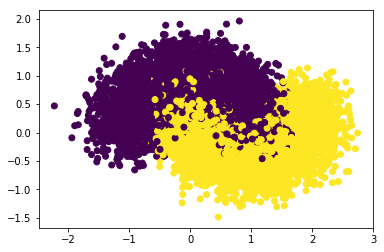

In [3]:
plt.scatter(X[:,0], X[:,1], c=y[:,0])
plt.show()

In [4]:
X.shape, y.shape

((9900, 2), (9900, 1))

In [5]:
def fully_connected_layer(inp, num_neurons, act=tf.nn.relu):
    # define model parameters and their initialization procedures:
    W = tf.Variable(tf.random_normal([int(inp.shape[1]), num_neurons], stddev=0.01), name='weight')
    b = tf.Variable(tf.random_normal([num_neurons], stddev=0.01), name='bias')
    
    x = tf.matmul(inp, W) + b # compute preactivation
      
    x = act(x) # apply nonlinearity
    
    x.set_shape([None, num_neurons]) # set shape which is passed to next layers. "None" means may be arbitrary
    
    return x

In [6]:
#build tensorflow model

X_ph = tf.placeholder(tf.float32, shape=[None, 2]) # we will put data here
y_ph = tf.placeholder(tf.float32) # and here

# 2 hidden layers with relu activations and 160 neurons each
d = fully_connected_layer(X_ph, 160)
d = fully_connected_layer(d, 160)

# output layer
y_hat = fully_connected_layer(d, 1, lambda x: x) # activation used here is a special trick for numerical stability

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_ph, logits=y_hat)) # special loss for classification

y_hat = tf.nn.sigmoid(y_hat)[:,0] # sigmoid outputs in range [0,1], indicates probability

In [7]:
train_op = tf.train.AdamOptimizer().minimize(loss) # compute gradients and apply them

In [8]:
sess = tf.Session() # create model variable manager

In [9]:
initializer = tf.global_variables_initializer() # create parameter initializer

In [10]:
sess.run(initializer) # initialize model variables

In [11]:
train_op = [loss, train_op]

In [12]:
def run_train(X, y):
    return sess.run(train_op, feed_dict={X_ph:X, y_ph:y})[0] #run train_op and return loss

In [13]:
ix = np.arange(len(X))
losses_train = []
losses_val = []
batch = 100
ix = 0

with sess.as_default():
    for _ in range(5000):
        if ix + batch > len(X):
            ix = 0
        X_, y_ = X[ix:ix+batch], y[ix:ix+batch]
        ix += batch
        
        #track train and validation losses:
        losses_train.append(run_train(X_, y_))
        
        losses_val.append(loss.eval(feed_dict={X_ph: X_val, y_ph: y_val}))

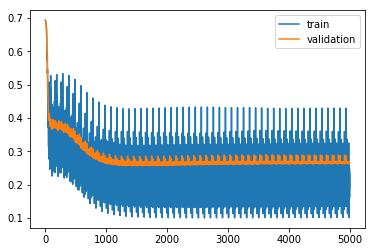

In [14]:
tr, = plt.plot(range(len(losses_train)), losses_train, label='train')
val, = plt.plot(range(len(losses_val)), losses_val, label='validation')
plt.legend(handles=[tr,val])

plt.show()

In [15]:
def plot_pic():
    floatX = 'float32'
    
    n = 80
    start = np.min(X, axis=0)
    stop = np.max(X, axis=0)
    d = (stop - start)/n
    xi, yi = np.meshgrid(np.arange(start[0], stop[0], d[0]), np.arange(start[1], stop[1], d[1]))
    joined = np.stack([xi, yi], axis=-1)
    joined = joined.reshape((-1, 2))
    
    preds = np.zeros((n,n), dtype=floatX)

    for _ in range(100):
        preds_ = sess.run(y_hat, {X_ph:joined})
        preds += preds_.reshape((n, n))
    
    plt.imshow(preds)
    plt.show()

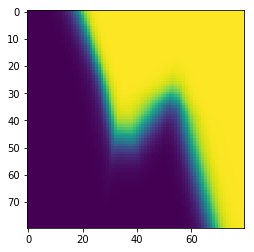

In [16]:
plot_pic()

In [17]:
sess.close()